## Data 

In [23]:
import numpy as np
import h5py
import pandas as pd
import tensorflow as tf
from keras.losses import categorical_crossentropy
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc

In [2]:
f = h5py.File("data/processed-pythia82-lhc13-all-pt1-50k-r1_h022_e0175_t220_nonu_withPars_truth_0.z",'r')
treeArray = f['t_allpar_new'][()]

In [33]:
import itertools
x = [len(list(y)) for _,y in itertools.groupby(treeArray['j_index'])]
j_cIndex = np.array([],dtype='int8')

for i in x:
    new_jet_index = np.arange(i)
    j_cIndex = np.append(j_cIndex, new_jet_index)

In [34]:
split_index = np.array([])
for i in range(len(x)):
    if i%2470 == 0:
        split_index = np.append(split_index,np.sum(x[:i]))
split_index = np.append(split_index,np.sum(x))
split_index = split_index.astype(int)

In [35]:
ds_index = treeArray['index']
ds_JCPT = treeArray['j1_pt']
ds_JCETA = treeArray['j1_eta']
ds_JCPHI = treeArray['j1_phi']
ds_JCMASS = treeArray['j_mass']
ds_Nconstituents = treeArray['j_multiplicity']
ds_constituents_index = j_cIndex
ds_JCDELTAETA = treeArray['j1_etarot']
ds_JCDELTAPHI = treeArray['j1_phirot']
ds_PT = treeArray['j_pt']
ds_ETA = treeArray['j1_etarel']
ds_PHI = treeArray['j1_phirel']

ds_label = np.vstack((treeArray['j_g'],treeArray['j_q'],treeArray['j_w'],treeArray['j_z'],treeArray['j_t'])).T

In [38]:
Label = ['index', 'JCPT', 'JCETA', 'JCPHI', 'JCMASS', 'Nconstituents', 'constituents_index', 'JCDELTAETA', 'JCDELTAPHI', 'PT', 'ETA','PHI','label']
for i in range(len(split_index)-1):
    with h5py.File('data/Particle_data_%d.h5'%i, 'w') as f2:
        for lb in Label:
            f2.create_dataset(lb, data=eval('ds_%s'%lb)[split_index[i]:split_index[i+1]])

## Model

In [2]:
# ##------------calculate jet constituents energy, if you already had this information don't use it.
# def jce_np(jcpt, jceta, jcmass):
#     jcp = jcpt*np.cosh(jceta)
#     return (jcp**2+jcmass**2)**0.5


# #-------- attach integers to your keys  this example is : 'index' -> 0-th data, 'JCPT' ->1-th data
# # and 'index' is event index
# # 'JCPT' is constituents transvers momentum (PT)
# # 'JCETA' is constituents ETA
# # 'JCPHI' is constituents angle around beam axis
# # 'Ncontituents' is Number of constituents in the jet which the constitunt belong
# # 'constiteunts_index' is constituents index in each jet ('constiteunts' is typo)
# # 'JCDELTAETA' is constituents ETA related to jet axis
# # 'JCDELTAPHI' is constituents ETA related to jet axis
# # 'PT' is transvers momentum (PT) of jet which which the constitunt belong
# # 'ETA' is ETA of jet which which the constitunt belong
# # 'PHi' is PHI of jet which which the constitunt belong


# Labels = ['index', 'JCPT', 'JCETA', 'JCPHI', 'JCMASS', 'Nconstituents', 'constituents_index', 'JCDELTAETA', 'JCDELTAPHI', 'PT', 'ETA', 'PHI']
# _index, _jcpt, _jceta, _jcphi, _jcmass, _Ncons, _consindex, _jcdelteta, _jcdeltphi, _jpt, _jeta, _jphi = (i for i in range(len(Labels)))

# ##--------------------------------------------------h5py file to ParticleNet input structure
# def h5_to_data(h5path):
#     Data = {'mask':[], 'points':[], 'features':[]}
#     f = h5py.File(h5path,'r')
#     fc = np.array([f[lb][()] for lb in Labels])
#     fc = fc.transpose((1,0))
#     j0 = fc[0][_index]
    
#     JCE = jce_np(fc[:,_jcpt], fc[:,_jceta], fc[:,_jcphi])
#     logpt = np.log(fc[:,_jcpt])
#     loge = np.log(JCE)
#     relatpt = fc[:,_jcpt]/fc[:,_jpt]
#     mask, features, points = np.zeros((100,1)), np.zeros((100,8)), np.zeros((100,2)) # prepare constituents list
#     Nfc = len(fc)
#     for j in range(len(fc)):
#         if fc[j][_Ncons]>100:
#             if j< Nfc-1:
#                 j0 = fc[j+1][_index]
#             continue
#         if fc[j][_index]!=j0:
#             j0 = fc[j][_index]
#             Data['mask'].append(mask)
#             Data['points'].append(points)
#             Data['features'].append(features)
#             mask, features, points = np.zeros((100,1)), np.zeros((100,8)), np.zeros((100,2)) # prepare constituents list
#             continue
#         jc = int(fc[j][_consindex])
# #         jce = JCE[j]
        
#         points[jc] = np.array([fc[j][_jcdelteta], fc[j][_jcdeltphi] ])
#         mask[jc] = logpt[j]
#         features[jc] = np.array([logpt[j], loge[j], fc[j][_jcdelteta],fc[j][_jcmass], fc[j][_jcdeltphi], relatpt[j], fc[j][_jeta], fc[j][_jphi]])
#     return Data

# ##==========================================================================================
# ##----------merging 2 sample with ParticleNet input structure
# def merging(gg,qq):
#     total={}
#     total['mask']=gg["mask"]+qq["mask"]
#     total['features']=gg["features"]+qq["features"]
#     total['points']=gg['points']+qq['points']
#     return total
# ##--------- seperate inputs to training, validation and testing with ratio you give
# def separatedata(features_list,y,rateval,ratetest):
#     features_train, features_test, features_val={},{},{}
#     from sklearn.model_selection import train_test_split
#     mask = features_list["mask"]
#     features = features_list["features"]
#     points = features_list["points"]
#     X_ind = [i for i in range(len(y))]
#     X_train, X_ind, y_train, y_ind = train_test_split(X_ind, y, test_size=rateval+ratetest)
#     N=int(len(X_ind)*rateval/(rateval+ratetest))
#     X_val, X_test = X_ind[:N], X_ind[N:]
#     y_val, y_test = y_ind[:N], y_ind[N:]
#     features_train['mask']=np.array([mask[i] for i in X_train])
#     features_train['features']=np.array([features[i] for i in X_train])
#     features_train['points']=np.array([points[i] for i in X_train])
    
#     features_test['mask']=np.array([mask[i] for i in X_test])
#     features_test['features']=np.array([features[i] for i in X_test])
#     features_test['points']=np.array([points[i] for i in X_test])
    
#     features_val['mask']=np.array([mask[i] for i in X_val])
#     features_val['features']=np.array([features[i] for i in X_val])
#     features_val['points']=np.array([points[i] for i in X_val])
    
#     return features_train, features_val, features_test,np.array(y_train), np.array(y_val), np.array(y_test)

In [ ]:
##------------calculate jet constituents energy, if you already had this information don't use it.
def jce_np(jcpt, jceta, jcmass):
    jcp = jcpt*np.cosh(jceta)
    return (jcp**2+jcmass**2)**0.5


#-------- attach integers to your keys  this example is : 'index' -> 0-th data, 'JCPT' ->1-th data
# and 'index' is event index
# 'JCPT' is constituents transvers momentum (PT)
# 'JCETA' is constituents ETA
# 'JCPHI' is constituents angle around beam axis
# 'Ncontituents' is Number of constituents in the jet which the constitunt belong
# 'constiteunts_index' is constituents index in each jet ('constiteunts' is typo)
# 'JCDELTAETA' is constituents ETA related to jet axis
# 'JCDELTAPHI' is constituents ETA related to jet axis
# 'PT' is transvers momentum (PT) of jet which which the constitunt belong
# 'ETA' is ETA of jet which which the constitunt belong
# 'PHi' is PHI of jet which which the constitunt belong


Labels = ['index', 'JCPT', 'JCETA', 'JCPHI', 'JCMASS', 'Nconstituents', 'constituents_index', 'JCDELTAETA', 'JCDELTAPHI', 'PT', 'ETA', 'PHI']
_index, _jcpt, _jceta, _jcphi, _jcmass, _Ncons, _consindex, _jcdelteta, _jcdeltphi, _jpt, _jeta, _jphi = (i for i in range(len(Labels)))

##--------------------------------------------------h5py file to ParticleNet input structure
def h5_to_data(h5path):
    Data = {'mask':[], 'points':[], 'features':[]}
    f = h5py.File(h5path,'r')
    fc = np.array([f[lb][()] for lb in Labels])
    fc = fc.transpose((1,0))
    j0 = fc[0][_index]
    
    JCE = jce_np(fc[:,_jcpt], fc[:,_jceta], fc[:,_jcphi])
    logpt = np.log(fc[:,_jcpt])
    loge = np.log(JCE)
    relatpt = fc[:,_jcpt]/fc[:,_jpt]
    mask, features, points = np.zeros((100,1)), np.zeros((100,8)), np.zeros((100,2)) # prepare constituents list
    Nfc = len(fc)
    for j in range(len(fc)):
        if fc[j][_Ncons]>100:
            if j< Nfc-1:
                j0 = fc[j+1][_index]
                jc =0 
            continue
        if fc[j][_index]!=j0:
            j0 = fc[j][_index]
            jc =0 
            Data['mask'].append(mask)
            Data['points'].append(points)
            Data['features'].append(features)
            mask, features, points = np.zeros((100,1)), np.zeros((100,8)), np.zeros((100,2)) # prepare constituents list
            continue
        jc = int(fc[j][_consindex])
#         jce = JCE[j]
        
        points[jc] = np.array([fc[j][_jcdelteta], fc[j][_jcdeltphi] ])
        mask[jc] = logpt[j]
        features[jc] = np.array([logpt[j], loge[j], fc[j][_jcdelteta],fc[j][_jcmass], fc[j][_jcdeltphi], relatpt[j], fc[j][_jeta], fc[j][_jphi]])
        jc = jc+1
    return Data

##==========================================================================================
##----------merging 2 sample with ParticleNet input structure
def merging(gg,qq):
    total={}
    total['mask']=gg["mask"]+qq["mask"]
    total['features']=gg["features"]+qq["features"]
    total['points']=gg['points']+qq['points']
    return total
##--------- seperate inputs to training, validation and testing with ratio you give
def separatedata(features_list,y,rateval,ratetest):
    features_train, features_test, features_val={},{},{}
    from sklearn.model_selection import train_test_split
    mask = features_list["mask"]
    features = features_list["features"]
    points = features_list["points"]
    X_ind = [i for i in range(len(y))]
    X_train, X_ind, y_train, y_ind = train_test_split(X_ind, y, test_size=rateval+ratetest)
    N=int(len(X_ind)*rateval/(rateval+ratetest))
    X_val, X_test = X_ind[:N], X_ind[N:]
    y_val, y_test = y_ind[:N], y_ind[N:]
    features_train['mask']=np.array([mask[i] for i in X_train])
    features_train['features']=np.array([features[i] for i in X_train])
    features_train['points']=np.array([points[i] for i in X_train])
    
    features_test['mask']=np.array([mask[i] for i in X_test])
    features_test['features']=np.array([features[i] for i in X_test])
    features_test['points']=np.array([points[i] for i in X_test])
    
    features_val['mask']=np.array([mask[i] for i in X_val])
    features_val['features']=np.array([features[i] for i in X_val])
    features_val['points']=np.array([points[i] for i in X_val])
    
    return features_train, features_val, features_test,np.array(y_train), np.array(y_val), np.array(y_test)

In [3]:
N = 40
Data = {'mask':[], 'points':[], 'features':[]}
for i in tqdm(range(N)):
    h5Path = "data/Particle_data_"+str(i)+".h5"
    data = h5_to_data(h5Path)
    Data = merging(Data,data)
print("check shape: ",Data['mask'][0].shape,Data['points'][0].shape,Data['features'][0].shape)

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [02:48<00:00,  4.22s/it]


check shape:  (100, 1) (100, 2) (100, 7)


In [4]:
# ## binary calssification: 
# y=[[0,1] for i in range(len(Data['mask']))]+[[1,0] for i in range(len(Data2['mask']))] 
# total = merging(Data, Data2)

y = h5py.File(h5Path)['label'][()]

# del Data
X_train, X_val, X_test, y_train, y_val, y_test = separatedata(Data,y,0.25,0.25)

D:\Softwares\Anacoda\envs\tf2\lib\site-packages\ipykernel_launcher.py:5: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  """


In [5]:
## check the shape
print([X_train[i][0].shape for i in ['mask', 'points', 'features']])

[(100, 1), (100, 2), (100, 7)]


In [6]:
import sys
sys.path.insert(0,'models')
from tf_keras_model import get_particle_net_lite

In [7]:
input_shapes={'points': X_train['points'][0].shape, 'features': X_train['features'][0].shape, 'mask': X_train['mask'][0].shape}
num_classes = 5
model = get_particle_net_lite(num_classes, input_shapes)

In [11]:
batch_size = 200
epochs = 3

In [12]:
opt = tf.keras.optimizers.Adam(lr=1e-4)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "ParticleNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
mask (InputLayer)               [(None, 100, 1)]     0                                            
__________________________________________________________________________________________________
tf_op_layer_NotEqual (TensorFlo [(None, 100, 1)]     0           mask[0][0]                       
__________________________________________________________________________________________________
tf_op_layer_Cast (TensorFlowOpL [(None, 100, 1)]     0           tf_op_layer_NotEqual[0][0]       
__________________________________________________________________________________________________
tf_op_layer_Equal (TensorFlowOp [(None, 100, 1)]     0           tf_op_layer_Cast[0][0]           
________________________________________________________________________________________

__________________________________________________________________________________________________
tf_op_layer_Neg_1 (TensorFlowOp [(None, 100, 100)]   0           tf_op_layer_add_4[0][0]          
__________________________________________________________________________________________________
tf_op_layer_range_1 (TensorFlow [(None,)]            0           tf_op_layer_strided_slice_3[0][0]
__________________________________________________________________________________________________
tf_op_layer_TopKV2_1 (TensorFlo [(None, 100, 8), (No 0           tf_op_layer_Neg_1[0][0]          
__________________________________________________________________________________________________
tf_op_layer_Reshape_1 (TensorFl [(None, 1, 1, 1)]    0           tf_op_layer_range_1[0][0]        
__________________________________________________________________________________________________
tf_op_layer_strided_slice_2 (Te [(None, 100, 7)]     0           tf_op_layer_TopKV2_1[0][1]       
__________

In [13]:
history = model.fit(X_train ,y_train,
          batch_size=batch_size,
          epochs=epochs, 
          validation_data=(X_val, y_val),
          shuffle=True ,
#           callbacks=callbacks
         )
model.evaluate(X_test,  y_test, verbose=2)

Train on 63767 samples, validate on 31884 samples
Epoch 1/3
63767/63767 [==============================] - 489s 8ms/sample - loss: 1.5636 - accuracy: 0.2862 - val_loss: 1.8329 - val_accuracy: 0.2744
Epoch 2/3
63767/63767 [==============================] - 457s 7ms/sample - loss: 1.5636 - accuracy: 0.2861 - val_loss: 2.4497 - val_accuracy: 0.2744
Epoch 3/3
63767/63767 [==============================] - 460s 7ms/sample - loss: 1.5637 - accuracy: 0.2861 - val_loss: 2.6622 - val_accuracy: 0.2744
31884/31884 - 41s - loss: 2.0211 - accuracy: 0.2795


[2.0211398405167915, 0.2795446]

## Evaluation

Text(0.25, 0.9, 'Particle_lite')

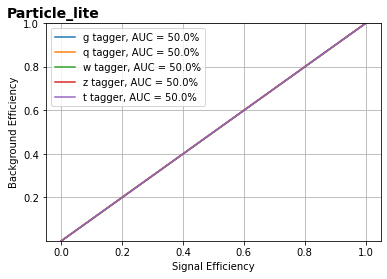

In [51]:
predict_test = model.predict(X_test)
predict_test = predict_test.transpose((1,0))
# y_test = y_test.transpose((1,0))
labels = ['g','q','w','z','t']
df = pd.DataFrame()
fpr = {}
tpr = {}
auc1 = {}
plt.figure()       
for i, label in enumerate(labels):
    df[label] = y_test[i]
    df[label + '_pred'] = predict_test[i]
    fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])
    auc1[label] = auc(fpr[label], tpr[label])
    plt.plot(tpr[label],fpr[label],label='%s tagger, AUC = %.1f%%'%(label.replace('j_',''),auc1[label]*100.))
plt.semilogy()
plt.xlabel("Signal Efficiency")
plt.ylabel("Background Efficiency")
plt.legend(loc='upper left')
plt.ylim(0.001,1)
plt.grid(True)

plt.figtext(0.25, 0.90,'Particle_lite',fontweight='bold', wrap=True, horizontalalignment='right', fontsize=14)

In [47]:
plt.figure(figsize=(10,8))
plt.plot(history.history['loss'], linewidth=1)
plt.plot(history.history['val_loss'], linewidth=1)
plt.title('Loss of Simple GRU')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training sample loss','validation sample loss'])
plt.show()
plt.close()

NameError: name 'history' is not defined

<Figure size 720x576 with 0 Axes>